### (5,5) eps = 0.1 当最初的策略一直向左 ，且目的地在左边的时候

---

由于经验要一个完整的 episode 才会更新，但是走到右边的概率非常非常小，所以很难收敛

In [85]:
%matplotlib inline
import sys
from collections import defaultdict

if "../" not in sys.path:
    sys.path.append("../")
    
import numpy as np
from lib.envs.GridEnv import Env
from lib.utils.draw import show_grid,show_policy,draw_line
import matplotlib

env = Env( (5, 5),p=0.4,seed=6,punish=-10)

In [86]:
def get_epsilon_policy(Q,nA,num_episodes):
    
    # 逐渐递减的 eps
    explore_frac = 0.1
    epsilon = lambda i: 1 - 0.99 * min(1, i / (num_episodes * explore_frac))

    def policy_fn(observation,i_episode):
        # eps = epsilon(i_episode)
        eps = 0.3
        A = np.ones(nA) * eps / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1 - eps)
        return A
    return policy_fn

In [87]:
def on_policy_MC(env,num_episodes,gamma=1.0,epsilon=0.1):
    
    # param initial 
    Q = np.zeros( (env.observation_size,env.action_size) )
    Q_cnt = np.zeros( (env.observation_size,env.action_size) )
    policy = get_epsilon_policy(Q,env.action_size,num_episodes)
    stats = defaultdict(lambda: [])
    
    # stats flag
    last_cnt = 0
    las_rewards = 0
    
    for i_episode in range(num_episodes):
        if i_episode % 1000 == 0:
            print(f"\rEpisode :{i_episode/num_episodes * 100:.2f}% steps: {last_cnt:5}, rewards: {las_rewards:5}",end = "")
            sys.stdout.flush()
        
        # env initial
        last_cnt = 0
        las_rewards =0
        state = env.reset()
        stack_state_action = []
        stack_reward = []
        
        while True:
            probs = policy(state,i_episode)
            action = np.random.choice( range(len(probs)), p=probs )
            next_state, reward, done = env.step(action)
            # print(f" state:{state},action:{action},reward:{reward},done:{done}")
            stack_state_action.append( (state,action) )
            stack_reward.append(reward)
            # update stats
            last_cnt += 1
            las_rewards += reward
            
            if done:
                break
            state = next_state
        # append stats
        stats['steps'].append(last_cnt)
        stats['rewards'].append(las_rewards)
        
        # policy improvement
        size = len(stack_state_action)
        G = 0
        for i in range(size-1,-1,-1):
            state, action = stack_state_action[i]
            
            G = gamma * G + stack_reward[i]
            if stack_state_action[i] not in stack_state_action[0:i]:
                Q_cnt[state][action] += 1
                Q[state][action] =  Q[state][action] + (1 / Q_cnt[state][action]) * ( G - Q[state][action])
    return Q,stats
    
    

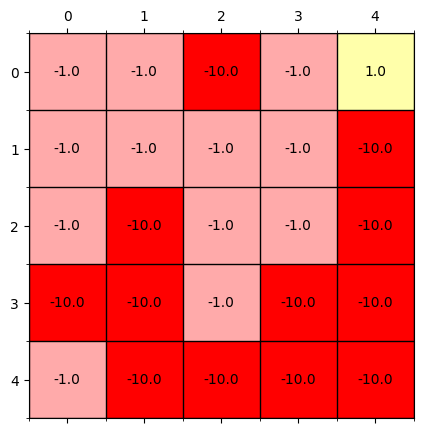

Episode :0.00% steps:     0, rewards:     0

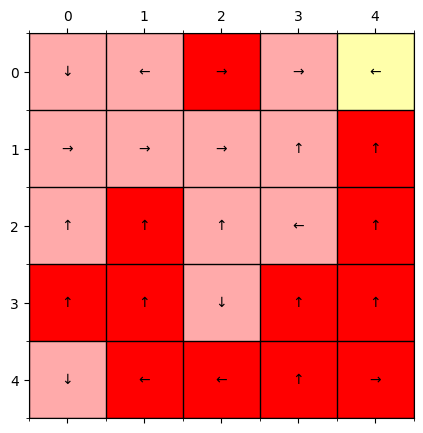

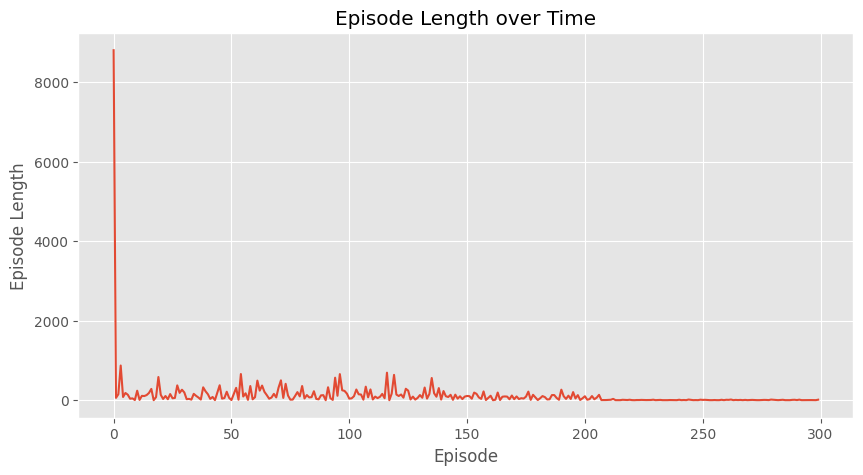

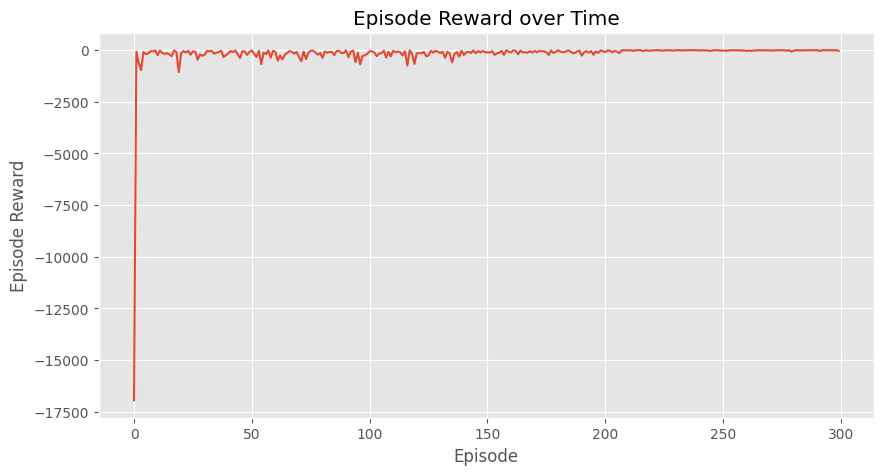

In [88]:
show_grid(env,env.grid)
num_episodes = 300
Q,stats = on_policy_MC(env,num_episodes=num_episodes,gamma=0.9)
V = np.zeros( env.observation_size )
policy = np.zeros_like(Q)
for i in range(len(V)):
    best_action = np.argmax(Q[i])
    V[i] = Q[i][best_action]
    policy[i][best_action] = 1
show_policy(env,policy)
draw_line(stats)


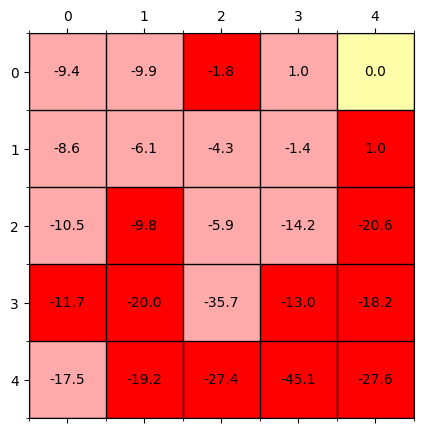

In [89]:
show_grid(env,V)